In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import find_contours, label, regionprops
from scipy.spatial.distance import cdist
from scipy.fft import fft, fftfreq
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [2]:
# Compute mass center of a given mask
def extract_centroid(mask):
    # Label distinct patches from the given mask
    labels = label(mask, connectivity=2)
    
    # Compute label properties
    props = regionprops(labels)
    
    # Keep only largest patch
    idx_max_area = np.argmax([x['area'] for x in props])
    
    # Return centroid (mass center)
    return np.array(props[idx_max_area]['centroid']).reshape((1, 2))


# Find the start of the petiole
def extract_petiole_start_pt(leaf_mask):
    # If the leaf mask is noisy we mark the various "patches" with different labels
    labels = label(leaf_mask, connectivity=2)
    props = regionprops(labels)
    
    # Pick up only the largest "patch"
    idx_max_area = np.argmax([x['area'] for x in props])
    main_mask = labels == props[idx_max_area]['label']
    
    # Compute the mass center of the mask
    main_centroid = np.array(props[idx_max_area]['centroid']).reshape((1, 2))
    all_pix_coords = np.transpose(np.nonzero(main_mask))
    
    # The farthest pixel from the mass center is the start of the petiole
    farthest_pix_idx = np.argmax(cdist(main_centroid, all_pix_coords))
    return all_pix_coords[farthest_pix_idx:(farthest_pix_idx + 1), :]



# Extract leaf contour
def extract_leaf_contour(leaf_mask):
    return find_contours(leaf_mask)[0]



# Rotate the contour so that it starts at the base of the petiole
# "pt_towards_plant_center" is a point towards the center of the plant, not the center of the leaf.
def make_contour_start_at_petiole_base(leaf_contour, pt_towards_plant_center):
    petiole_start_idx = np.argmin(cdist(pt_towards_plant_center, leaf_contour))
    return np.roll(leaf_contour, -petiole_start_idx, axis = 0)



# Calculate the length of each contour segment and return the cumulative contour length 
def cumulative_contour_length(contour):
    contour_length = np.zeros((len(contour),), dtype=float)
    contour_length[1:] = np.cumsum(np.sqrt(np.sum(np.square(contour[:-1, :] - contour[1:, :]),
                                                  axis=1)))
    return contour_length



# Take the length of a contour, map it to [0...1] and pick a point on the contour at the given ratio
def point_at_contour_ratio(contour, length_ratio, desired_ratio):
    # Pick the closest contour point after the given ratio
    idx = np.where(length_ratio >= desired_ratio)[0][0]
    if length_ratio[idx] == desired_ratio:
        # There is a precise contour point which is located at the desired ratio
        return contour[idx, :]
    
    # Find a point in between two contour points that lies at the desired point
    rest_ratio = desired_ratio - length_ratio[idx]
    rest_ratio_weigth = rest_ratio / (length_ratio[idx] - length_ratio[idx - 1])
    return (1 - rest_ratio_weigth) * contour[idx - 1, :] + rest_ratio_weigth * contour[idx, :]



# Extract leaf vein based on the leaf contour.
# "top_idx" represents the contour index of the top of the leaf
def extract_leaf_vein(leaf_contour, top_idx):
    # Compute left and right contours and the cumulative distances along each one,
    # as well as ratio values of each point along the contour it belongs to.
    left_contour = leaf_contour[:(1 + top_idx), :]
    right_contour = np.roll(leaf_contour, -1, axis=0)[(top_idx - 1):, :][::-1, :]  # Reverse order in order to start from petiole
    left_cum_length = cumulative_contour_length(left_contour)
    right_cum_length = cumulative_contour_length(right_contour)
    left_ratio = left_cum_length/left_cum_length[-1]
    right_ratio = right_cum_length/right_cum_length[-1] #  [x/right_cum_length[-1] for x in right_cum_length]

    # Pick the number of desired points along the leaf vein
    #     n_pts = max(left_contour.shape[0], right_contour.shape[0])
    n_pts = 20
    leaf_vein = np.zeros((n_pts, 2), dtype=float)
    for i_pt in range(n_pts):
        curr_ratio = i_pt / (n_pts - 1)
        
        # Leaf vein points are calculated as halfway through the distance between
        # the points on left/right contours located at the same relative ratio
        leaf_vein[i_pt, :] = (point_at_contour_ratio(left_contour, left_ratio, curr_ratio) 
                              + point_at_contour_ratio(right_contour, right_ratio, curr_ratio)) / 2.0
    return leaf_vein



# Calculate a moving average along a given data vector "a"
# If radius is 2 the moving window has 1+2*radius size (1 for the middle element) 
def moving_average(a, radius):
    # w_sz is the window size
    w_sz = 1 + 2 * radius
    avg_res = np.zeros_like(a, dtype=float)
    
    # Compute cumulative sum
    a_cumsum = np.zeros((1 + a.size), dtype=float)  # One artificial zero is added at the beginning
    a_cumsum[1:] = np.cumsum(a, dtype=float)
    
    # Most average values can be computed as differences between the cumulative sum values at locations
    # found at w_sz distance from each other
    avg_res[radius:(a.size - radius)] = (a_cumsum[w_sz:] - a_cumsum[:(a.size - w_sz + 1)]) / w_sz
    
    # Some values at the beginning and at the end need special attention
    avg_res[0] = a[0]
    avg_res[-1] = a[-1]
    for idx in range(1, radius):
        curr_w_sz = 1 + 2 * idx
        avg_res[idx] = a_cumsum[curr_w_sz] / curr_w_sz
        avg_res[a.size - idx - 1] = (a_cumsum[-1] - a_cumsum[a.size - curr_w_sz]) / curr_w_sz
    return avg_res


In [3]:
# Compute the intersection between an infinite line and a limited segment
# Points a and b define the line, points c and d define the segment
def line_segment_intersection(a, b, c, d):
    # The denominator comes from a special mathematical formula
    denominator = (a[0] - b[0]) * (c[1] - d[1]) - (a[1] - b[1]) * (c[0] - d[0])
    if denominator == 0:
        # The segment is parallel with the line. Return error.
        return False, None
        
    # Parametric values of the intersection:
    # t is between 0 and 1 if the intersection falls between the two points (a and b) of the line
    # u is between 0 and 1 if the intersection falls between the two points (c and d) of the segment
    t = ((a[0] - c[0]) * (c[1] - d[1]) - (a[1] - c[1]) * (c[0] - d[0])) / denominator
    u = ((a[0] - c[0]) * (a[1] - b[1]) - (a[1] - c[1]) * (a[0] - b[0])) / denominator

    # Check if lines actually intersect
    if (0 <= u <= 1):
        # Intersection falls inside the segment
        return True, np.array([a[0] + t * (b[0] - a[0]), a[1] + t * (b[1] - a[1])], dtype=float).reshape((1, 2))
    
    # Intersection falls outside the segment
    return False, None
    


# Compute the intersection between an infinite line (defined by two points) and a contour (a list of at least two points)
def line_contour_intersection(line, contour):
    intersection_pt = None
    intersection_seg_idx = -1
    min_intersection_dist = np.inf
    
    # Compute intersection of the line with each segment of the contour
    for seg_idx in range(contour.shape[0] - 1):
        intersection_found, curr_intersection_pt = line_segment_intersection(
            line[0, :], line[1, :], 
            contour[seg_idx, :], contour[seg_idx + 1, :])
        if intersection_found:
            curr_dist = cdist(line[:1, :], curr_intersection_pt)
            if curr_dist < min_intersection_dist:
                # Keep only the closest intersection
                intersection_pt = curr_intersection_pt
                intersection_seg_idx = seg_idx
                min_intersection_dist = curr_dist
    return intersection_pt, intersection_seg_idx



# Compute the distance from a point to an infinite line by projecting it orthogonally to the line
def distance_from_pt_to_line(pt, line):
    return np.linalg.norm(np.cross(-np.diff(line, axis=0), line[0, :] - pt)) / np.linalg.norm(-np.diff(line, axis=0))


In [4]:
# Resample the pts_2d contour to have new_n_pts points
def my_interp(pts_2d, new_n_pts):
    # Compute cumulative contour length
    init_cum_dists = [0.0] + np.cumsum(np.sum(np.square(pts_2d[:-1, :] - pts_2d[1:, :]), axis=1)).tolist()
    
    # Resample contour points
    new_cum_dists = np.linspace(0, init_cum_dists[-1], new_n_pts).tolist()
    new_y = np.interp(new_cum_dists, init_cum_dists, pts_2d[:, 0])
    new_x = np.interp(new_cum_dists, init_cum_dists, pts_2d[:, 1])
    
    return np.column_stack((new_y, new_x))


In [5]:
# Get leaf mask and features
def get_leaf(lobe_path, petiole_path):
    # Read leaf and petiole masks from file and combine them to form the leaf mask
    lobe_mask = np.max(cv2.imread(lobe_path), axis=2).astype(bool)
    petiole_mask = np.max(cv2.imread(petiole_path), axis=2).astype(bool)
    leaf_mask = np.logical_or(lobe_mask, petiole_mask)

    # Initialize petiole point as the centroid of the petiole mask
    petiole_pt = extract_centroid(petiole_mask)

    # Compute lobe contour and tip of the leaf
    lobe_contour = make_contour_start_at_petiole_base(extract_leaf_contour(lobe_mask), petiole_pt)
    top_idx = np.argmax(cdist(lobe_contour[:1, :], lobe_contour))

    return lobe_mask, petiole_pt, lobe_contour, top_idx



# (Fast) Fourier Transform analysis of the lobe mask
def fft_analysis(lobe_mask, petiole_pt, contour, top_idx, plot_spectrum=False):
    # Compute left and right contours
    left_contour = contour[:top_idx, :].copy()
    right_contour = np.roll(contour, -1, axis=0)[top_idx:, :][::-1, :].copy()  # Reverse order in order to start from petiole

    # Compute mass center of the lobe
    mid_pt = np.reshape(np.array(regionprops(lobe_mask)[0]['centroid']), (1, 2))

    # Resample left/right contours by a fixed number of points
    #     new_n_pts = 1 + 2 * (max(left_contour.shape[0], right_contour.shape[0]) - 1)
    new_n_pts = 1001
    new_left_contour = my_interp(left_contour, new_n_pts)
    new_right_contour = my_interp(right_contour, new_n_pts)
    new_contour = np.vstack([new_left_contour, new_right_contour[::-1, :]])
    
    if plot_spectrum:
        # Plot lobe an contours
        fig, ax = plt.subplots(1, 3)
        fig.set_size_inches(21, 10)
        ax_idx = 0
        ax[ax_idx].imshow(lobe_mask, cmap=plt.cm.gray)
        ax[ax_idx].plot(left_contour[:, 1], left_contour[:, 0], 'r', linewidth=3)
        ax[ax_idx].plot(right_contour[:, 1], right_contour[:, 0], 'y', linewidth=3)
        ax[ax_idx].plot(contour[0, 1], contour[0, 0], 'ro')
        ax[ax_idx].plot(contour[top_idx, 1], contour[top_idx, 0], 'yo')
        ax[ax_idx].plot(mid_pt[0, 1], mid_pt[0, 0], 'gx')
        ax[ax_idx].title.set_text('Leaf Lobe and Contour')
    #     plt.show()

    # Compute radial distance from the centroid to the lobe contour
    new_dists = cdist(mid_pt, new_contour).flatten()
    if plot_spectrum:
        # Plot radial distance
        ax_idx += 1
        ax[ax_idx].plot(np.linspace(0, 1, new_dists.size), new_dists.flatten())
        ax[ax_idx].title.set_text('Radial Distance to the Two Semi-Contours')
    #     plt.show()

    # Compute (Fast) Fourier Transform
    fft_shift = int(new_dists.size/2)
    new_y_fft = np.roll(fft(new_dists), fft_shift)
    new_x_fft = np.roll(fftfreq(new_dists.shape[-1]), fft_shift)
    if plot_spectrum:
        # Plot magnitude of the Fourier spectrum
        ax_idx += 1
        ax[ax_idx].plot(new_x_fft, np.abs(new_y_fft))
        ax[ax_idx].set_yscale('log')
        ax[ax_idx].title.set_text('Fourier Transform Magnitude')
        plt.show()

    return new_y_fft, new_x_fft


In [ ]:
# Perform analysis per leaf
def perform_analysis_per_leaf(leaf_path, file_list):
    leaf_data = []
    for filename in file_list:
        lobe_path = os.path.join(leaf_path, r'leaf seq\hidden leaf mask seq', filename)
        # The petiole is needed to find the part of the lobe closest to the plant center
        petiole_path = os.path.join(leaf_path, r'stem seq\hidden stem mask seq', filename)
        lobe_mask, petiole_pt, lobe_contour, top_idx = get_leaf(lobe_path, petiole_path)
        new_y_fft, new_x_fft = fft_analysis(lobe_mask.astype(int), petiole_pt, lobe_contour, top_idx, plot_spectrum=True)
        leaf_data.append((new_y_fft, new_x_fft))
    return leaf_data


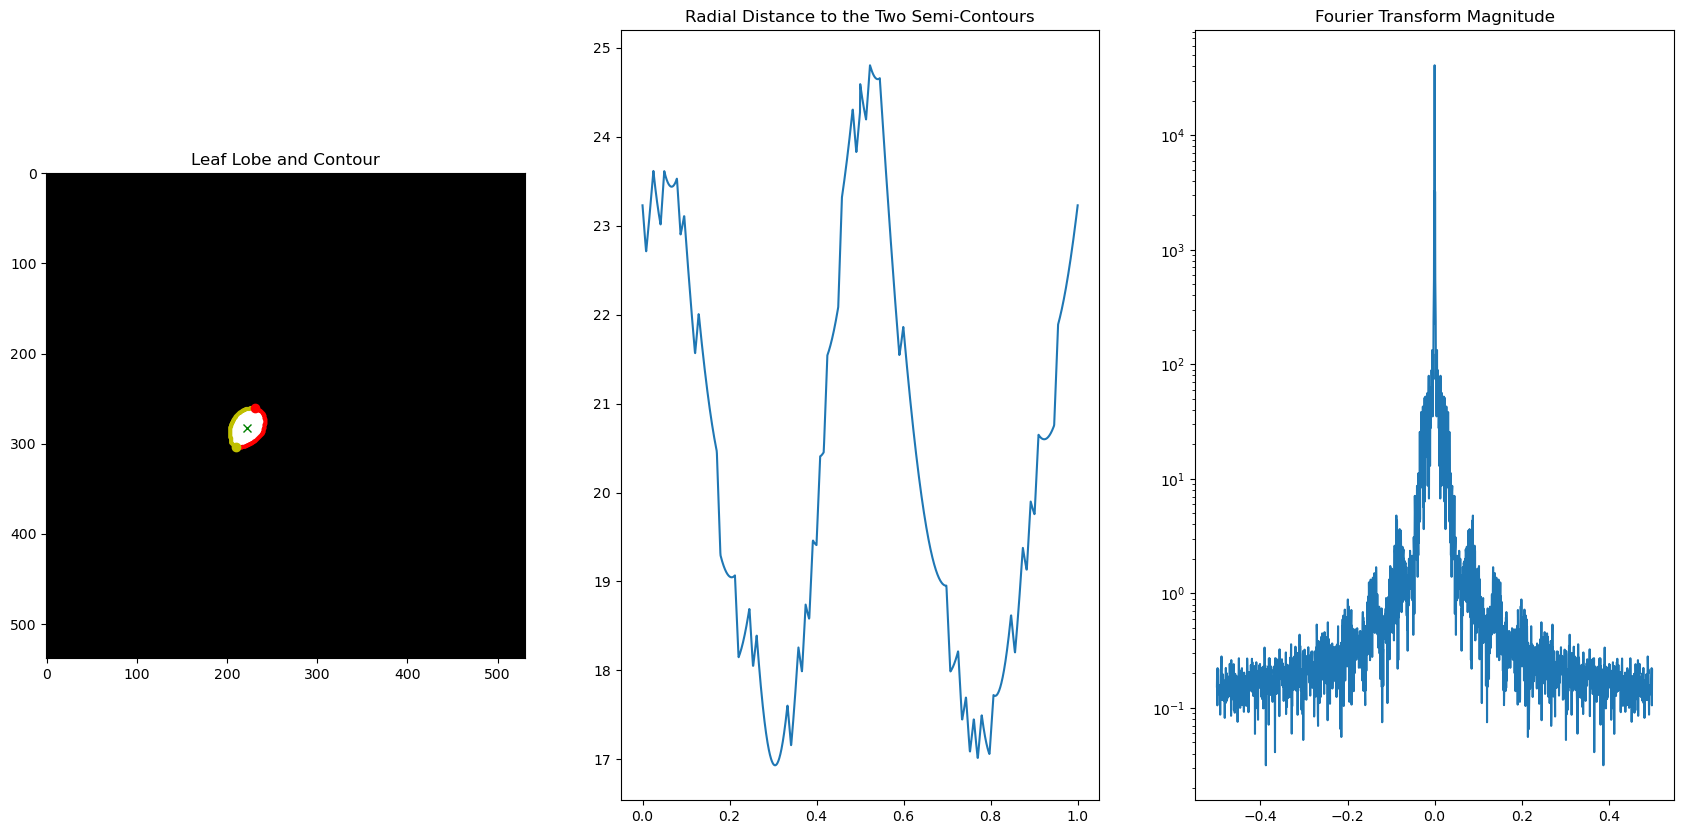

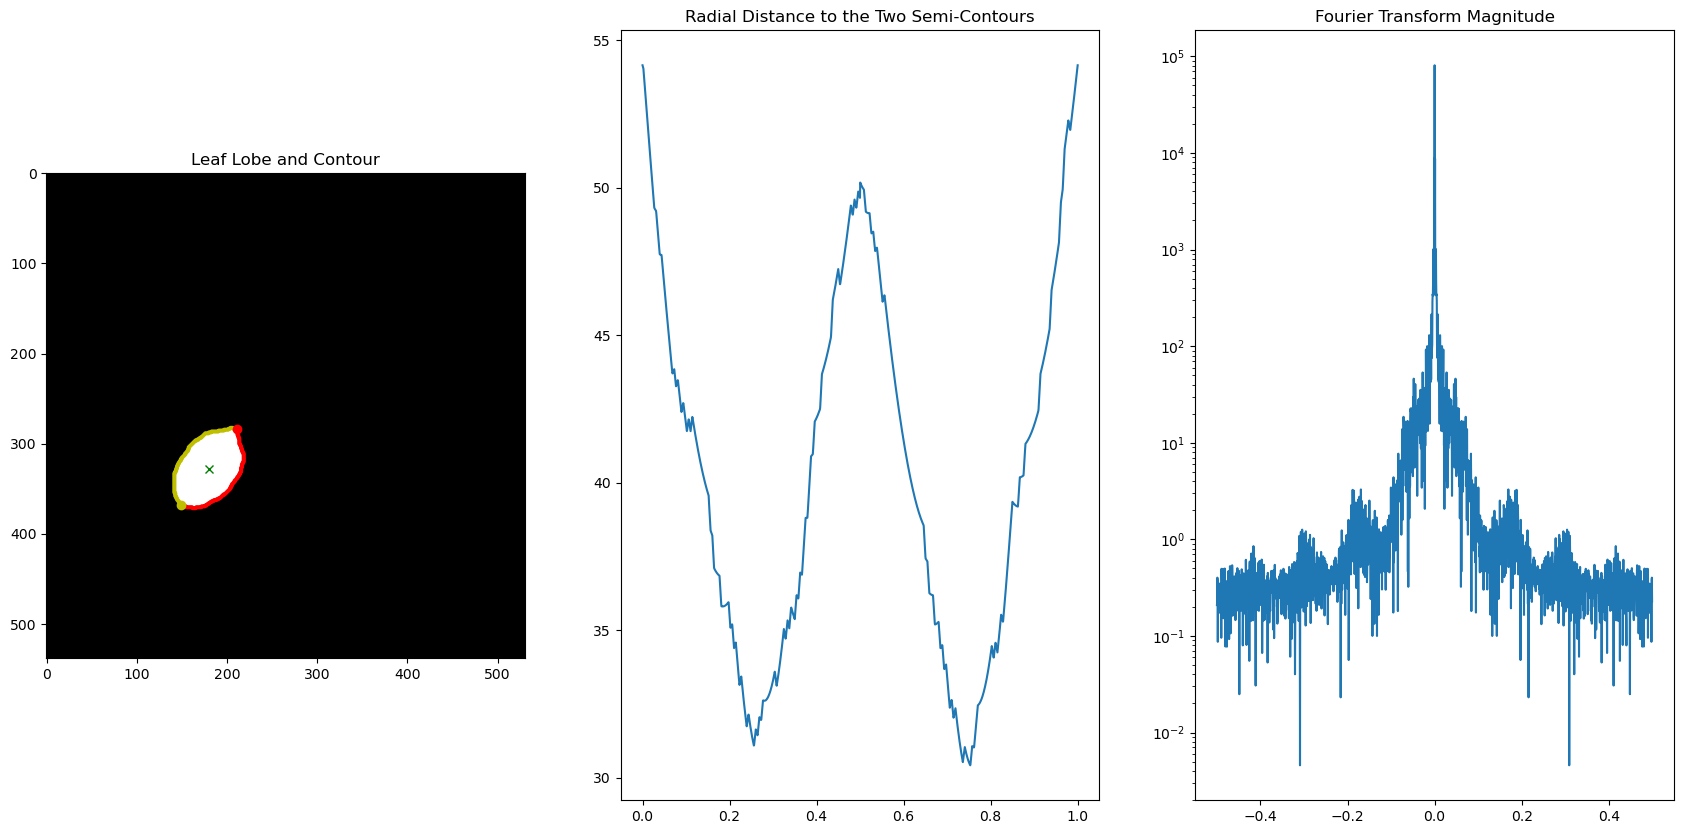

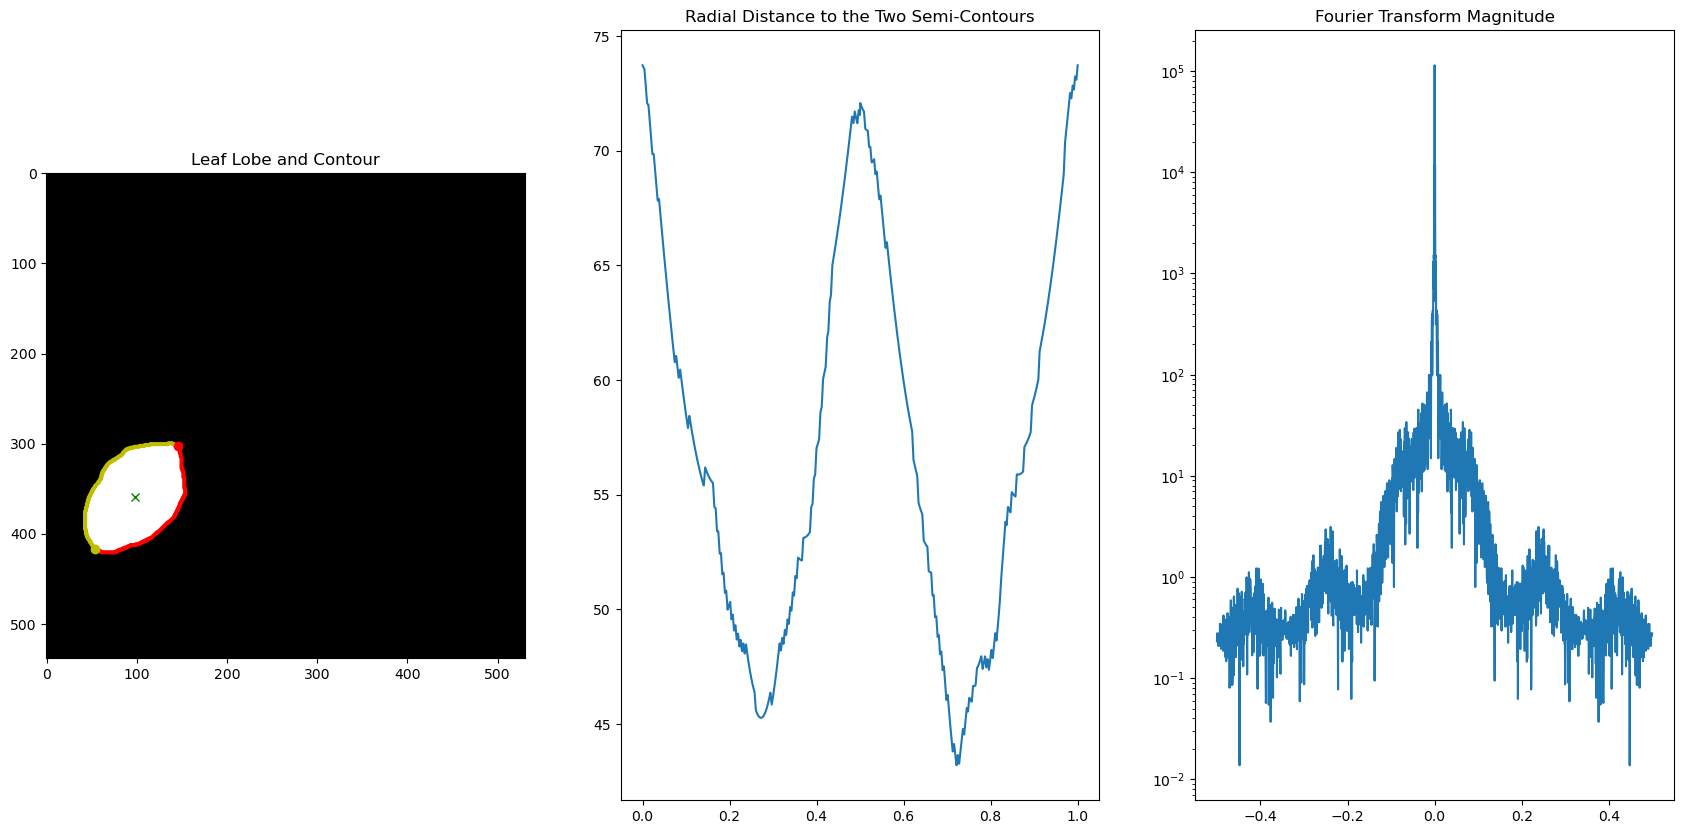

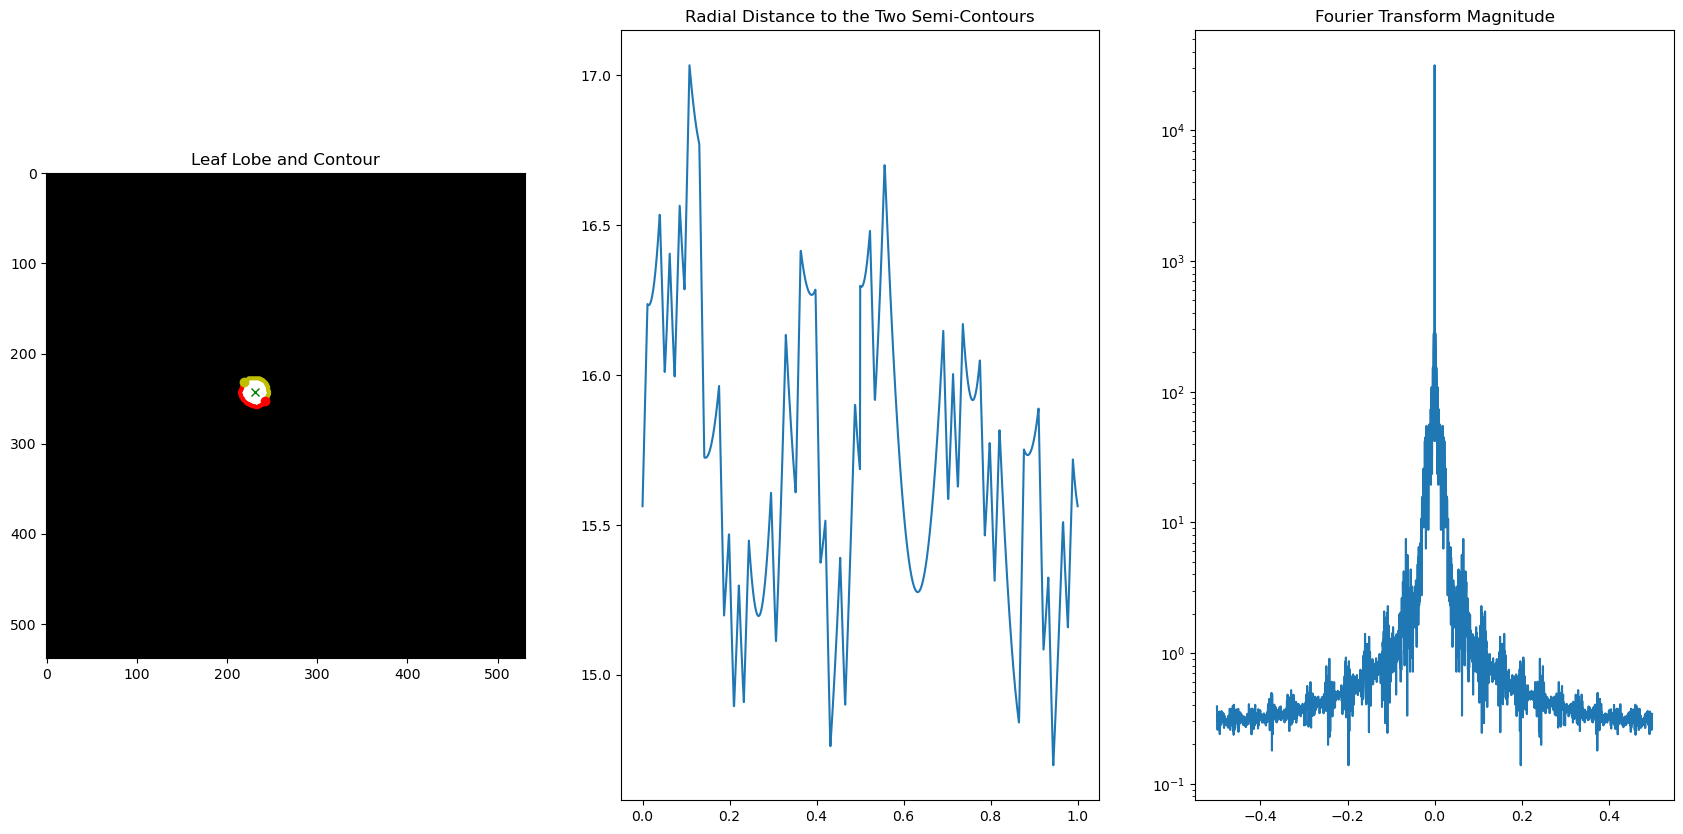

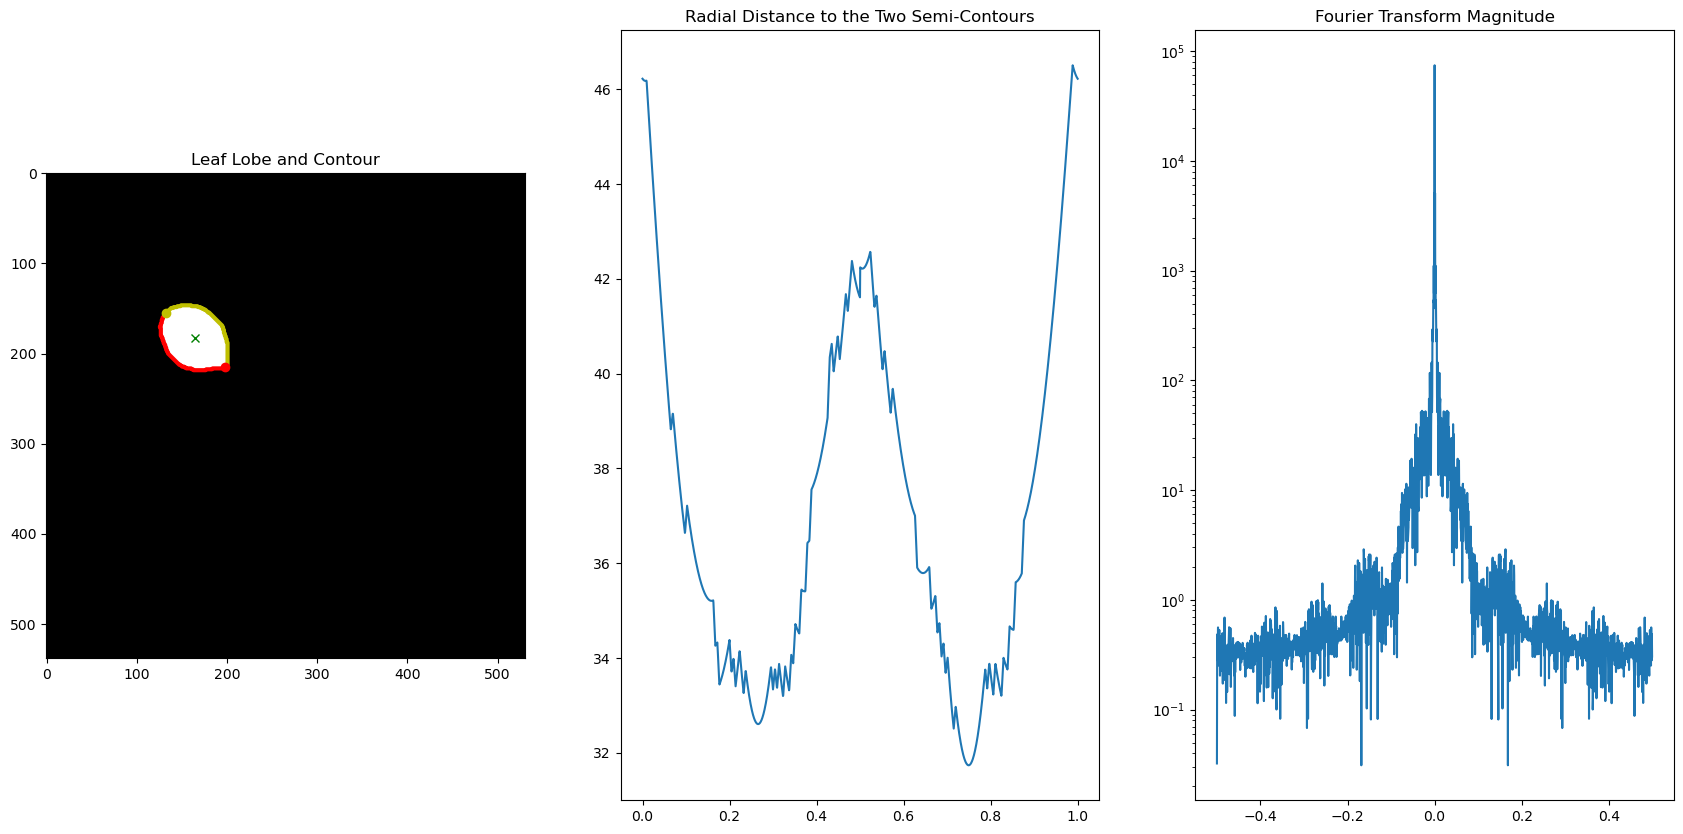

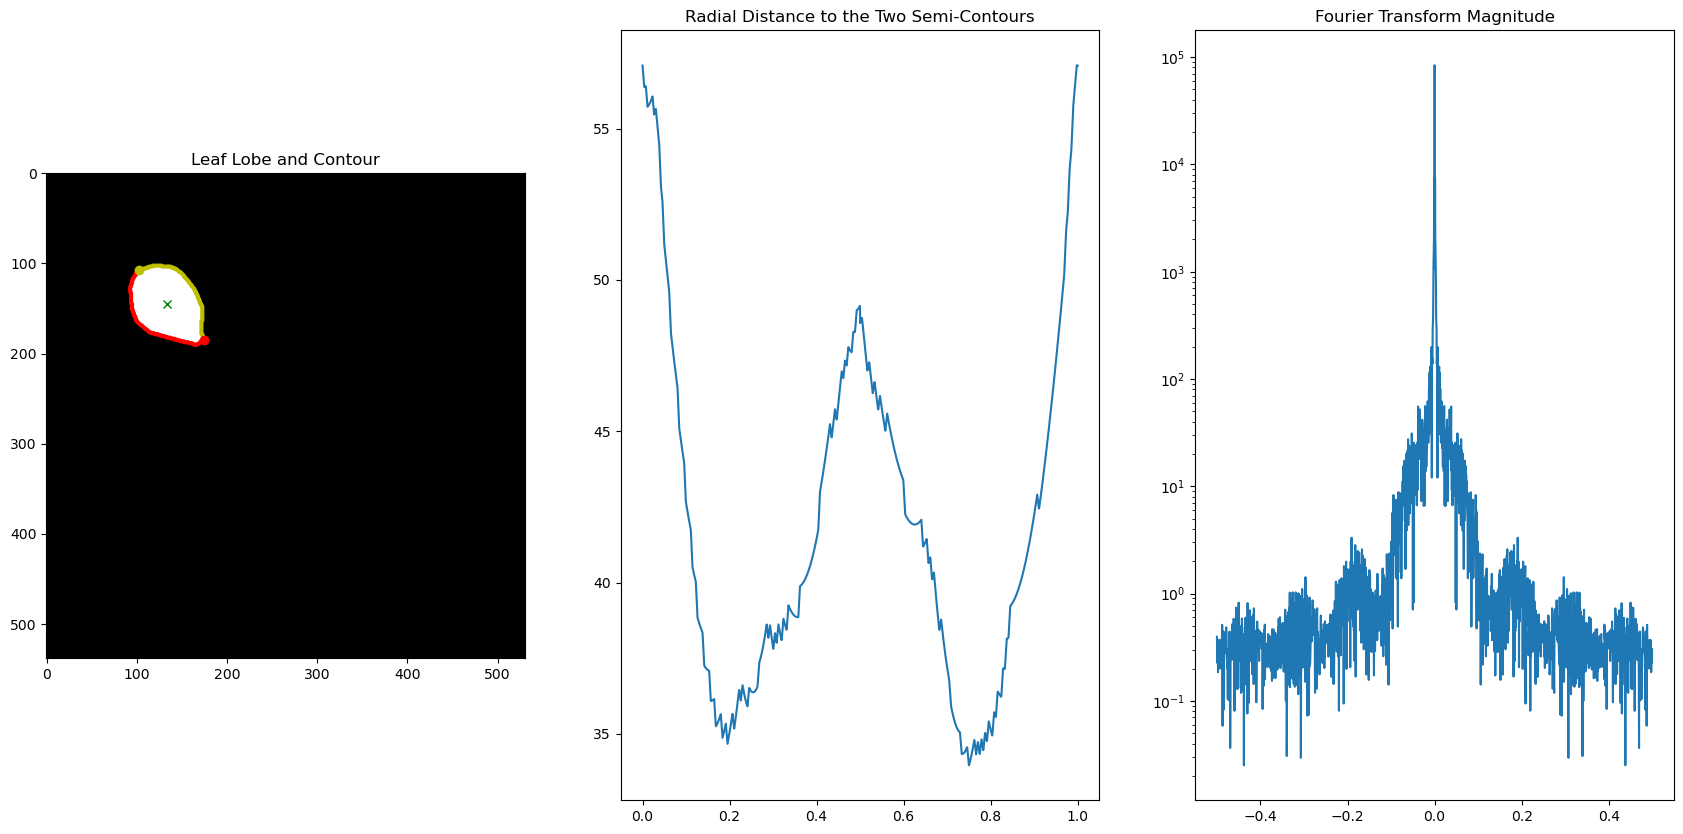

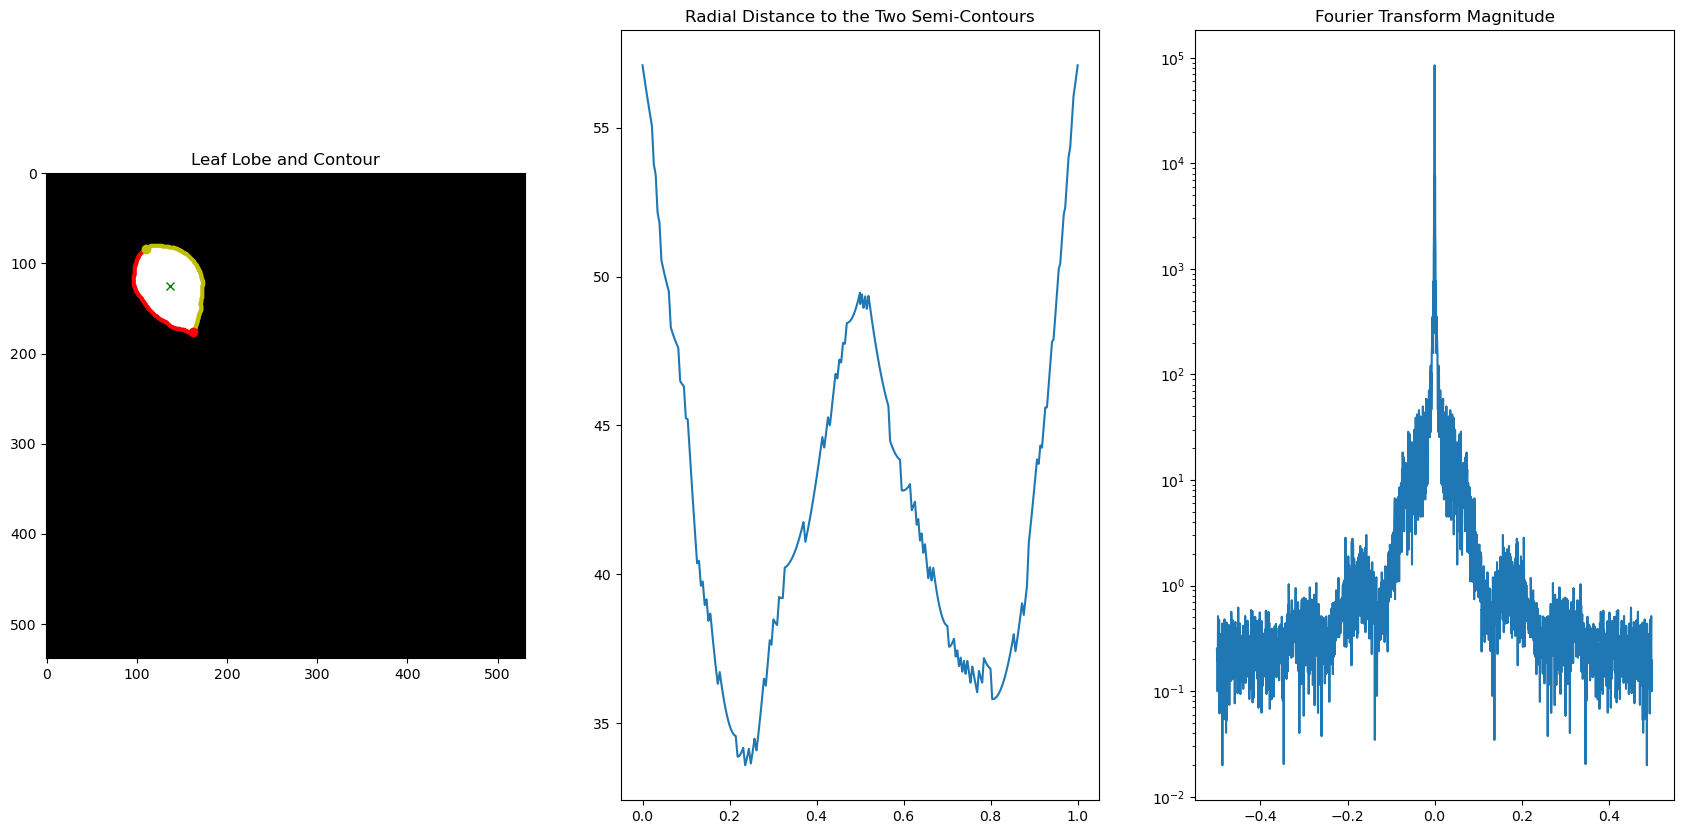

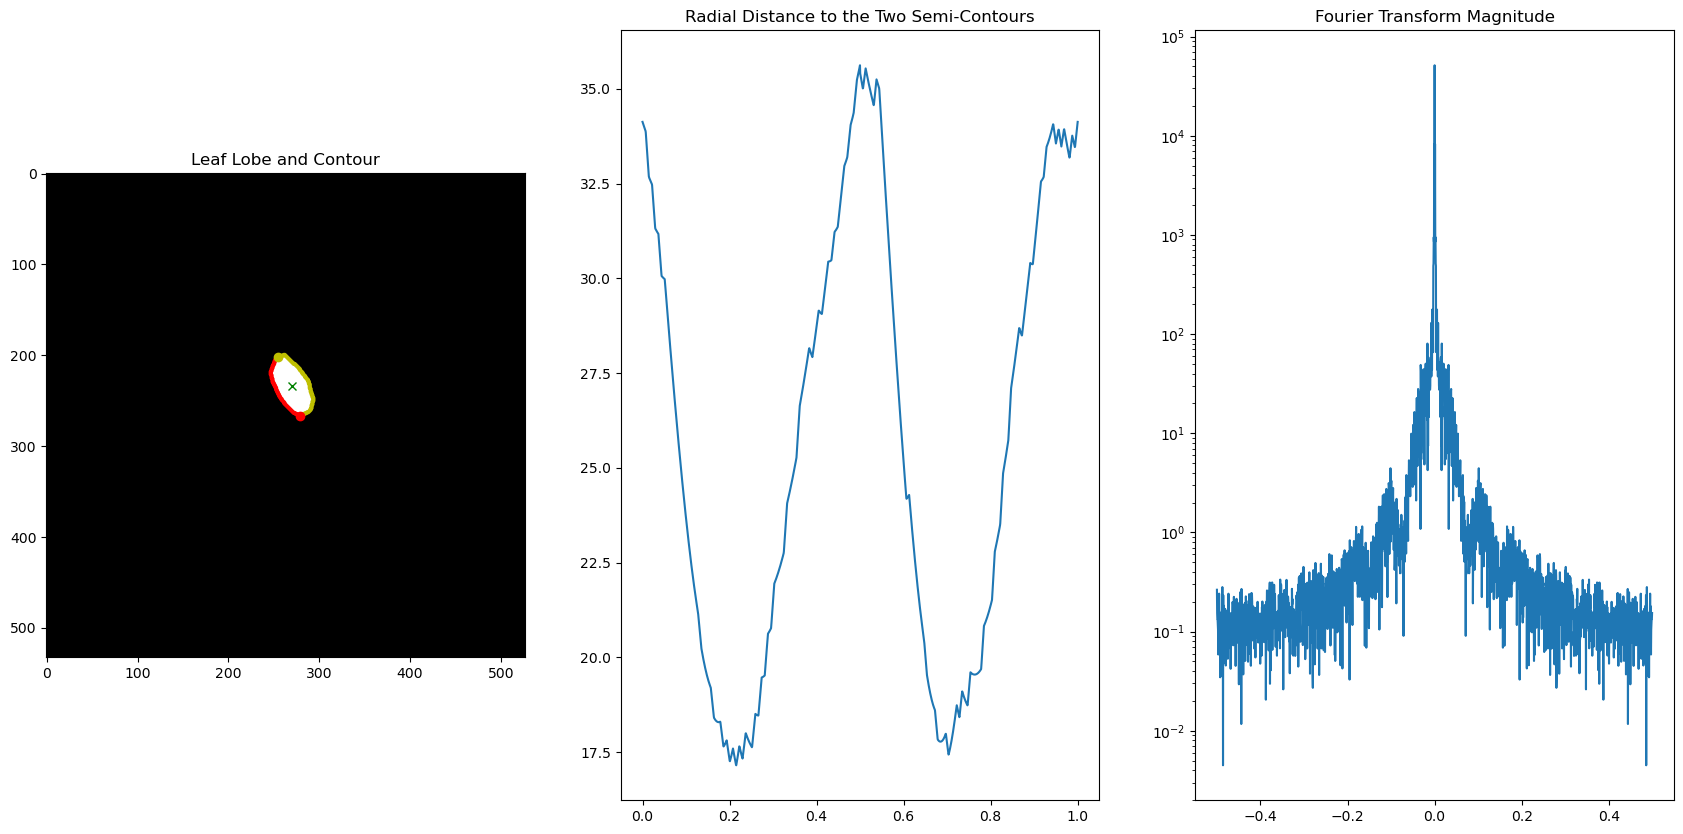

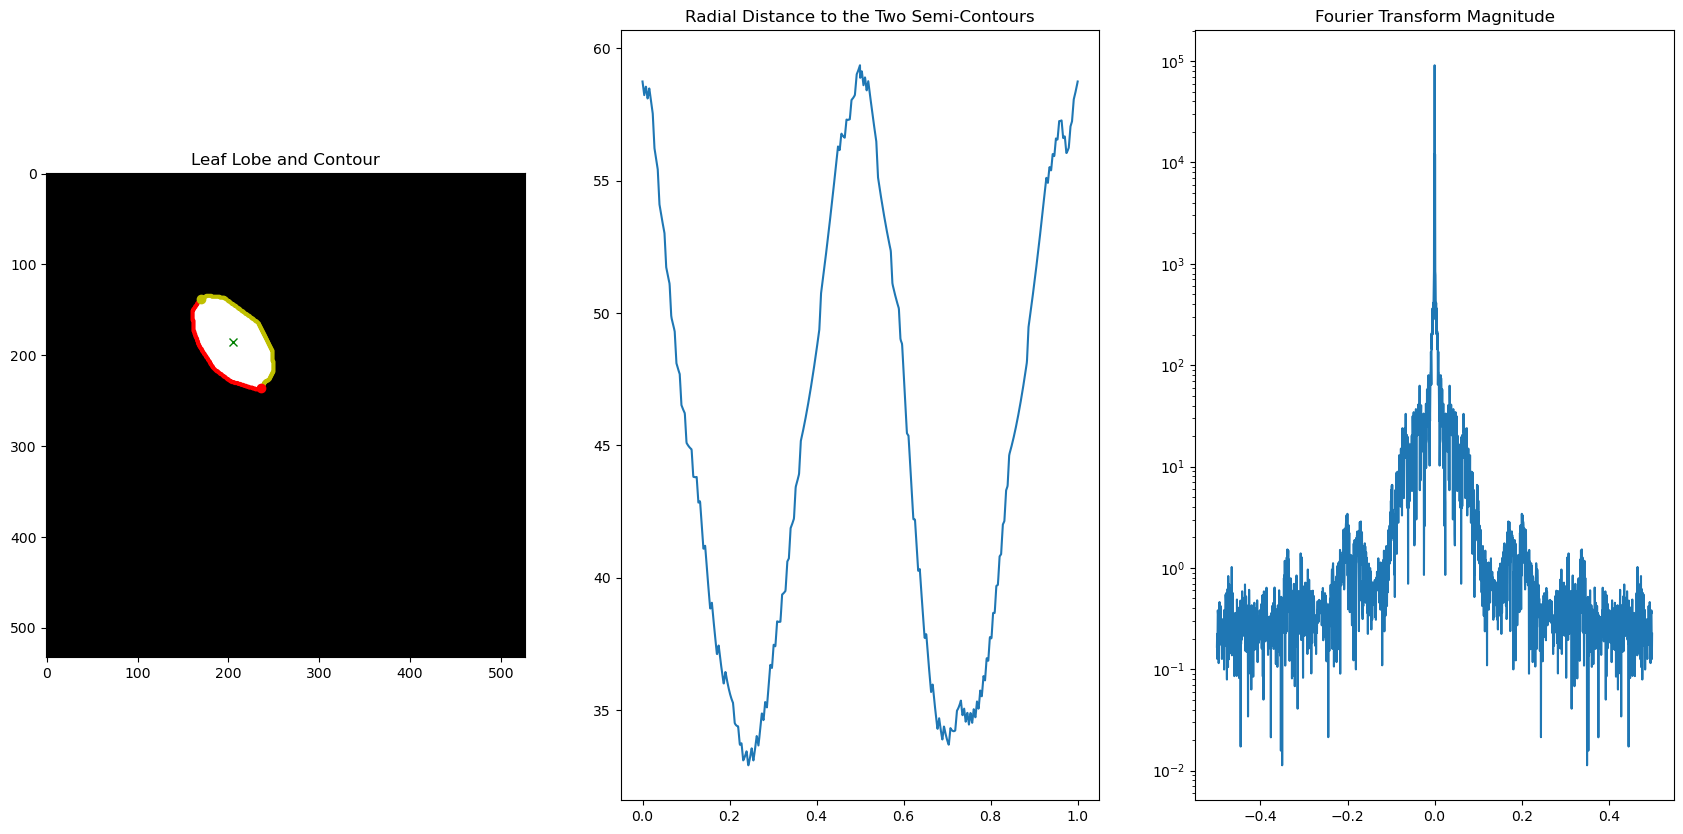

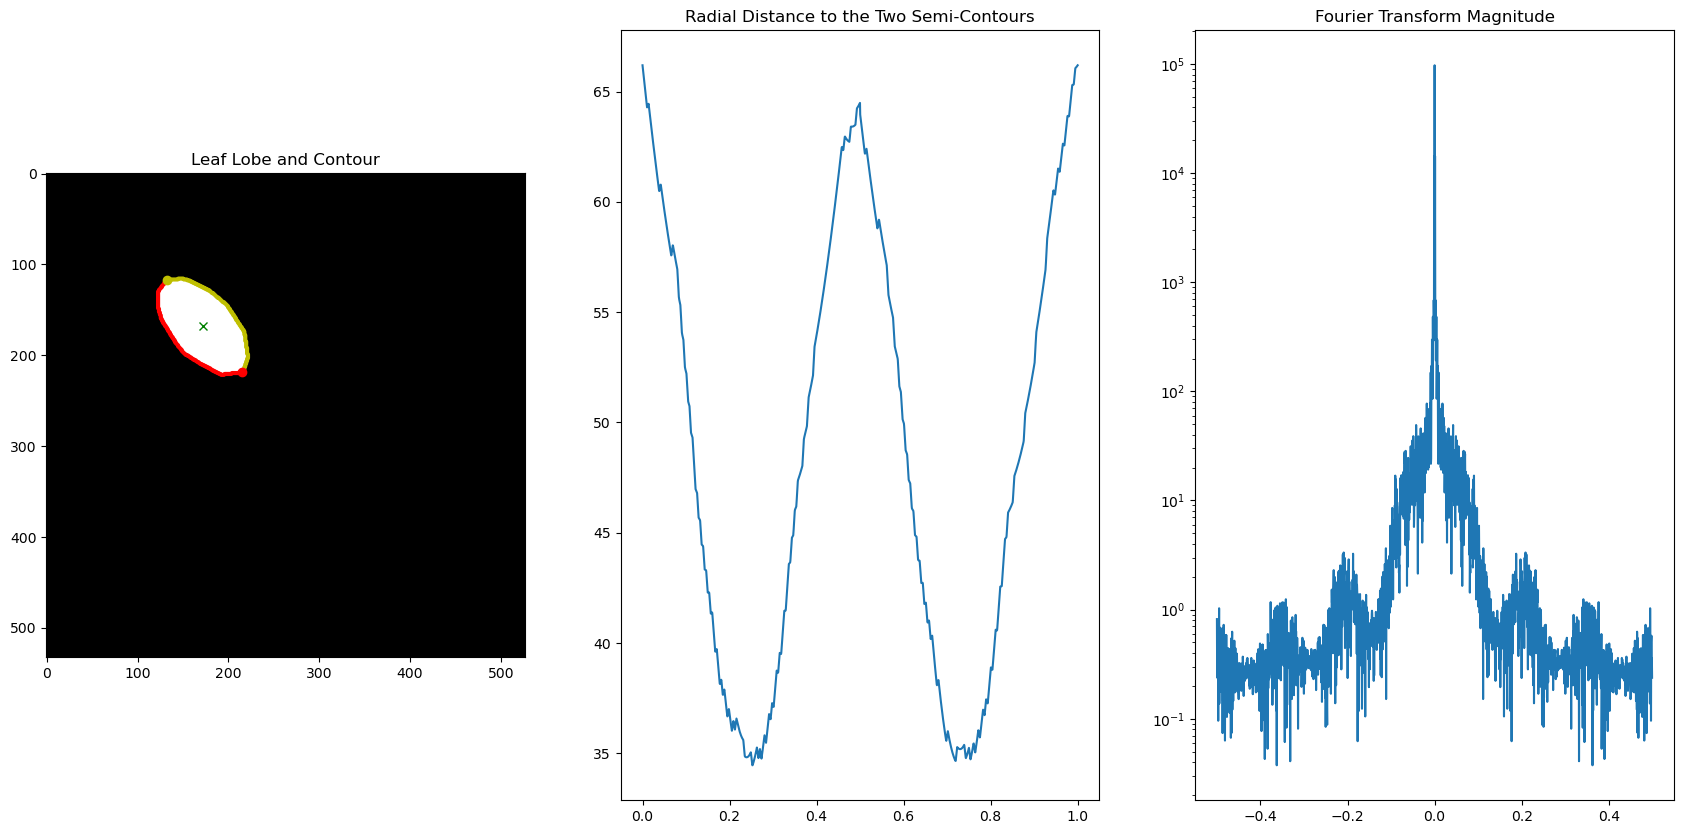

In [6]:
# Main experiment

all_leaf_data = dict()

root_path = r'D:\Projects\Plants_AU\Proj3\Data\masks_cust_org_08-02\masks_cust_org\masks_and_stems\leaf_dataset1\Ba4-1\rep_09\Leaf_007'
filenames = [r'1000412_2022_05_16_12_02_03-6-9-TC06-RGB1_pot_D5_Ba4-1-09.png',
             r'1000412_2022_05_19_12_02_03-6-15-TC06-RGB1_pot_D5_Ba4-1-09.png',
             r'1000412_2022_05_23_12_02_04-6-23-TC06-RGB1_pot_D5_Ba4-1-09.png']
all_leaf_data[root_path] = perform_analysis_per_leaf(root_path, filenames)


print('=====================================================================')

root_path = r'D:\Projects\Plants_AU\Proj3\Data\masks_cust_org_08-02\masks_cust_org\masks_and_stems\leaf_dataset1\Ba4-1\rep_09\Leaf_004'
filenames = [r'1000412_2022_05_13_12_02_03-6-3-TC06-RGB1_pot_D5_Ba4-1-09.png',
             r'1000412_2022_05_18_15_02_03-6-14-TC06-RGB1_pot_D5_Ba4-1-09.png',
             r'1000412_2022_05_22_15_02_04-6-22-TC06-RGB1_pot_D5_Ba4-1-09.png',
             r'1000412_2022_05_24_15_02_04-6-26-TC06-RGB1_pot_D5_Ba4-1-09.png']
all_leaf_data[root_path] = perform_analysis_per_leaf(root_path, filenames)


print('=====================================================================')

root_path = r'D:\Projects\Plants_AU\Proj3\Data\masks_cust_org_08-02\masks_cust_org\masks_and_stems\leaf_dataset1\Cvi-0\rep_03\Leaf_001'
filenames = [r'1000171_2022_05_20_12_02_26-6-17-TD02-RGB1_pot_D4_Cvi-0-03.png',
             r'1000171_2022_05_25_15_02_27-6-28-TD02-RGB1_pot_D4_Cvi-0-03.png',
             r'1000171_2022_05_31_15_02_26-6-40-TD02-RGB1_pot_D4_Cvi-0-03.png']
all_leaf_data[root_path] = perform_analysis_per_leaf(root_path, filenames)

    


In [7]:
# Separate Fourier spectrum int low and high frequency
def separate_spectrum(fft_y, cutoff_sz):
    fft_shift = int(fft_y.size / 2)
    low_freq_fft_grad_mag = fft_y[(fft_shift-cutoff_sz):(fft_shift+cutoff_sz)].copy()
#     low_freq_fft_x = fft_x[(fft_shift-cutoff_sz):(fft_shift+cutoff_sz)].copy()
    high_freq_fft_grad_mag = np.roll(fft_y, -fft_shift)[cutoff_sz:-cutoff_sz].copy()
#     high_freq_fft_x = np.roll(fft_x, -fft_shift)[cutoff_sz:-cutoff_sz].copy()
    return low_freq_fft_grad_mag, high_freq_fft_grad_mag

In [ ]:
# Lobe classification. The labels must be created manually by the user upon inspecting the original images
low_freq_X_train, low_freq_X_test, low_freq_y_train, low_freq_y_test = train_test_split(
    (list_of_low_freq_fft_grad_mag, list_of_low_freq_labels), random_state=42)

# Apply PCA to low frequency train and test data
pca_low = PCA(n_components=20)
low_freq_X_train_pca = pca_low.fit_transform(low_freq_X_train)
low_freq_X_test_pca = pca_low.fit(low_freq_X_test)

# Compute Random Forest model for the lobe
lobe_model = RandomForestClassifier(n_estimators=10)
lobe_model.fit(low_freq_X_train_pca, low_freq_y_train)

# Testing the model performance. The results should match low_freq_y_test
print(lobe_model.predict(low_freq_X_test_pca))

#########################

# Margin classification. The labels must be created manually by the user upon inspecting the original images
high_freq_X_train, high_freq_X_test, high_freq_y_train, high_freq_y_test = train_test_split(
    list_of_high_freq_fft_grad_mag, list_of_high_freq_labels, random_state=24)

# Apply PCA to high frequency train and test data
pca_high = PCA(n_components=20)
high_freq_X_train_pca = pca_high.fit_transform(hgh_freq_X_train)
high_freq_X_test_pca = pca_high.fit(high_freq_X_test)

# Compute Random Forest model for the margin
margin_model = RandomForestClassifier(n_estimators=10)
margin_model.fit(high_freq_X_train_pca, high_freq_y_train)

# Testing the model performance. The results should match high_freq_y_test
print(margin_model.predict(margin_freq_X_test_pca))
